In [1]:
# Standard Library Imports (if any)

# Third-party Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display, HTML
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects

# Local Module Imports
from utils import *
from new_data_handling import DataManager
from plot import *
from new_data_handling.data_processor import *

In [2]:
major = COUNTRIES.MAJOR
offshore = COUNTRIES.OFFSHORE
sample = major + offshore
period = (2001, 2004)
save = None
interpolate = False
dm = DataManager(
    raw_dir = "../data/raw",
    save_dir = "../data/clean"
)
ds_full = dm.get_dataset("ds")
fed_full = dm.get_dataset("fed")
# dm.clean_data()
# dm.save_data()

In [3]:
# Index returns
period = (2001, 2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
panel_dates = fed.columns
returns_index = compute_index_excess_returns(ds, fed, major)
returns_index = returns_index.stack().rename("returns")

# # Portfolio returns
# period = (2001, 2004)
# cpis = dm.cpis.get_data(period=period)
# wb = dm.wb.get_data(countries=major, period=period)
# weights = compute_weights(cpis, wb, major, offshore).mean(axis=1).unstack(level="Country")
# returns_portfolio = compute_portfolio_excess_returns(ds, fed, major, weights)

# World market return
returns_world = compute_index_excess_returns(ds, fed, ["WR"]).to_numpy().flatten()
returns_world_dummies = pd.DataFrame(0.0, index=returns_index.index, columns=major)
for country in major:
    returns_world_dummies.loc[(country, slice(None)), country] = returns_world
returns_world_dummies.columns = ['WRx' + str(col) for col in returns_world_dummies.columns]

# GDP per capita
interpolate=False
period = (2001, 2004) if not interpolate else (2000,2004)
gdp_cap_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_cap_ppp")
gdp_cap_ppp = create_monthly_duplicates(gdp_cap_ppp, panel_dates, interpolate=interpolate)
gdp_cap_ppp = gdp_cap_ppp.stack().rename("gdp_cap")

# GDP growth (lagged yearly)
d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
lags = range(1,2)
for lag in lags:
    period = (2000-lag,2004-lag) if not interpolate else (1999-lag,2004-lag)
    gdp_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_ppp")
    d_gdp_ppp = (gdp_ppp.diff(axis=1) / gdp_ppp).iloc[:,1:]
    d_gdp_ppp = create_monthly_duplicates(d_gdp_ppp, panel_dates, interpolate=interpolate)
    d_gdp_ppp_lag[f"d_gdp_{lag}"] = d_gdp_ppp.stack().rename(f"lag{lag}")

# GDP growth (lagged monthly)
# d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
# period = (1997,2004)
# n_lags = (2001 - period[0])*12
# columns = dm.ds.get_data(period=period, interval="M").columns[13:]
# d_gdp_ppp_lag = pd.DataFrame(index=returns_index.index)
# gdp_ppp = dm.gdp.get_data(countries=major, period=period, gdp_type="gdp_ppp")
# d_gdp_ppp = (gdp_ppp.diff(axis=1) / gdp_ppp).iloc[:,1:]
# d_gdp_ppp = create_monthly_duplicates(d_gdp_ppp, monthly_columns=columns, interpolate=interpolate)
# d_gdp_ppp
# lags = range(1, 37)
# for lag in lags:
#     d_gdp_ppp_lag[f"d_gdp_{lag}"] = d_gdp_ppp.iloc[:, 36-lag:-lag].T.unstack().to_numpy()
# d_gdp_ppp_lag = d_gdp_ppp_lag.iloc[:, range(0,1)]

# Cumulative GDP growth
d_gdp_ppp_cum = d_gdp_ppp_lag.sum(axis=1)

# Variances (rolling window, exponential decay)
def calculate_exponentially_weighted_variance(period, panel_dates, ratio):
    ds = dm.ds.get_data(period=period, interval="M")
    fed = dm.fed.get_data(period=period)
    returns_index_historical = compute_index_excess_returns(ds, fed, major)
    variances = pd.DataFrame(index=major, columns=panel_dates)
    for i in range(48):
        returns = returns_index_historical.iloc[:,i:i+60]
        means = returns.mean(axis=1)
        returns_demeaned = returns.sub(means, axis=0)
        var_contributions = returns_demeaned**2
        factors = generate_exponential_decay(ratio=ratio)
        vars = var_contributions.mul(factors).sum(axis=1) / sum(factors)
        variances.iloc[:,i] = vars
    variances = variances.stack().rename("variances").astype(float)
    return variances
variances = calculate_exponentially_weighted_variance((1996,2004), panel_dates, 0.9)

In [4]:
from scipy.optimize import minimize_scalar

period = (1996,2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
returns_index_historical = compute_index_excess_returns(ds, fed, major)
returns_index_demeaned = returns_index - returns_index.groupby("Country").mean()
returns_index_demeaned_squared = (returns_index_demeaned ** 2)

def compute_r2(kappa):
    variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, kappa)
    model = sm.OLS(returns_index_demeaned_squared, variances_kappa).fit(cov_type="HAC", cov_kwds={"maxlags": 4})
    return -model.rsquared


def compute_ss(kappa):
    variances_kappa = calculate_exponentially_weighted_variance(period, panel_dates, kappa)
    errors = variances_kappa - returns_index_demeaned_squared
    ss = (errors ** 2).to_numpy().sum()
    return ss

kappa_ss = minimize_scalar(compute_ss, bounds=(0,1), method="bounded")
kappa_r2 = minimize_scalar(compute_r2, bounds=(0,1), method="bounded")
print(kappa_r2.x, kappa_ss.x)

0.9096351858162872 0.8914021213249128


In [5]:
# Collect dependent and independent variables
scale = True
y = returns_index * (1e2 if scale else 1)
X = pd.concat([
    returns_world_dummies * (1e2 if scale else 1),
    # gdp_cap_ppp / (1e5 if scale else 1),
    d_gdp_ppp_cum * (1e2 if scale else 1),
    variances * (1e2 if scale else 1),
], axis=1)
X = sm.add_constant(X)

In [6]:
# Do statistics
from linearmodels.panel import PanelOLS, PooledOLS

model_panel = PanelOLS(y, X, entity_effects=True).fit(cov_type="kernel", kernel="bartlett", bandwidth=4)
model_pooled = PooledOLS(y,X).fit(cov_type="kernel", kernel="bartlett", bandwidth=4)

comparison = pd.DataFrame([model_pooled.params, model_panel.params], index=["pooled", "panel"])
date = model_panel.estimated_effects.index.get_level_values(1)[0]

effects = model_panel.estimated_effects.loc[(slice(None), date),:].droplevel(1)

if save is not None:
    save_dir = f"./output/exp3/results/"
    os.makedirs(save_dir, exist_ok=True)
    print(save_dir)
    with open(os.path.join(save_dir, f"{save}.txt"), "w") as f:
        f.write(model_panel.summary.as_text())
model_panel.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:                returns   R-squared:                        0.4443
Estimator:                   PanelOLS   R-squared (Between):             -0.2583
No. Observations:                1824   R-squared (Within):               0.4443
Date:                Tue, Apr 22 2025   R-squared (Overall):              0.4343
Time:                        00:32:27   Log-likelihood                   -5780.7
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      34.897
Entities:                          38   P-value                           0.0000
Avg Obs:                       48.000   Distribution:                 F(40,1746)
Min Obs:                       48.000                                           
Max Obs:                       48.000   F-statistic (robust):          2.876e+05
                                        P-value                           0.0000
Time periods:                      48   Distribution:                 F(40,1746)
Avg Obs:                       38.000                                           
Min Obs:                       38.000                                           
Max Obs:                       38.000                                           
                                                                                
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.8634     0.5905     1.4621     0.1439     -0.2948      2.0216
WRxAR          0.8728     0.2472     3.5313     0.0004      0.3881      1.3576
WRxAT          0.4591     0.1153     3.9819     0.0001      0.2330      0.6853
WRxBE          0.8536     0.1645     5.1888     0.0000      0.5310      1.1763
WRxBR          1.8543     0.2786     6.6560     0.0000      1.3079      2.4007
WRxCA          0.9428     0.0846     11.141     0.0000      0.7769      1.1088
WRxCH          0.8279     0.0707     11.711     0.0000      0.6892      0.9665
WRxCL          0.9817     0.1147     8.5579     0.0000      0.7567      1.2067
WRxCO          0.6833     0.1187     5.7554     0.0000      0.4505      0.9162
WRxCZ          0.7768     0.2057     3.7773     0.0002      0.3735      1.1802
WRxDE          1.4062     0.1189     11.831     0.0000      1.1731      1.6394
WRxDK          0.9625     0.0828     11.630     0.0000      0.8002      1.1249
WRxES          1.0702     0.0777     13.770     0.0000      0.9178      1.2227
WRxFI          1.6374     0.2517     6.5062     0.0000      1.1438      2.1310
WRxFR          1.2625     0.0711     17.756     0.0000      1.1231      1.4020
WRxGB          0.9024     0.0505     17.879     0.0000      0.8034      1.0014
WRxGR          1.0679     0.1701     6.2769     0.0000      0.7342      1.4016
WRxHK          1.0148     0.1049     9.6698     0.0000      0.8090      1.2206
WRxHU          0.9503     0.1585     5.9938     0.0000      0.6393      1.2612
WRxID          0.7374     0.2765     2.6667     0.0077      0.1951      1.2798
WRxIL          0.8979     0.1928     4.6579     0.0000      0.5198      1.2761
WRxIT          1.0944     0.0747     14.654     0.0000      0.9480      1.2409
WRxJP          0.6626     0.1054     6.2845     0.0000      0.4558      0.8693
WRxKR          1.5069     0.1757     8.5762     0.0000      1.1623      1.8515
WRxMX          0.9313     0.1146     8.1263     0.0000      0.7066      1.1561
WRxMY          0.4621     0.1307     3.5350     0.0004      0.2057      0.7185
WRxNL          1.1601     0.1194     

In [7]:
# Expected world return
period = (1991,2004)
ds = dm.ds.get_data(period=period, interval="M")
fed = dm.fed.get_data(period=period)
returns_world = compute_index_excess_returns(ds, fed, ["WR"])
returns_world_expectation = np.zeros(48)
for i in range(48):
    returns = returns_world.iloc[:,i:i+120]
    mean = returns.mean(axis=1).iloc[0]
    returns_world_expectation[i] = mean

In [8]:
params_for_estimation = model_panel.params.copy()
X_for_estimation = X.copy()
for country in major:
    world_return_header = "WRx" + country
    X_for_estimation.loc[(country, slice(None)), world_return_header] = returns_world_expectation
fitted_returns = (X_for_estimation * params_for_estimation)
fitted_returns = fitted_returns.sum(axis=1).unstack()
(fitted_returns < 0).sum(axis=1)

AR    0
AT    0
BE    0
BR    0
CA    0
CH    0
CL    0
CO    0
CZ    0
DE    0
DK    0
ES    0
FI    0
FR    0
GB    0
GR    0
HK    0
HU    0
ID    0
IL    0
IT    0
JP    0
KR    0
MX    0
MY    0
NL    0
NO    0
PH    0
PL    0
PT    0
RU    0
SE    0
SG    0
TH    0
TR    0
US    0
VE    0
ZA    0
dtype: int64

In [9]:
# Covariances 
returns = returns_index.unstack()
returns_mean = returns.mean(axis=1)
returns_demeaned = returns.sub(returns_mean, axis=0)
stds = variances.map(lambda x: np.sqrt(x)).unstack()
standardised_returns = returns_demeaned / stds / 100
corrs = standardised_returns.T.corr()
covs = pd.DataFrame(index=major, columns=pd.MultiIndex.from_product([stds.columns, major]))
for month in stds.columns:
    covs[month] = corrs.mul(stds[month],axis=1).mul(stds[month],axis=0)


In [10]:
# Covariance risks
period = (2001, 2004)
cpis = dm.cpis.get_data(period=period)
wb = dm.wb.get_data(countries=major, period=period)
weights_per_year = compute_weights(cpis, wb, major, offshore)
weights = weights_per_year.mean(axis=1).unstack(level="Country")
weights["MX"] = weights_per_year.loc["MX"][[2003,2004]].mean(axis=1)
cov_risks = pd.DataFrame(index=covs.index, columns=covs.columns)
cov_risks_diag = pd.DataFrame(index=covs.index, columns=stds.columns)
for month in stds.columns:
    temp = covs[month] @ weights
    cov_risks[month] = temp
    cov_risks_diag[month] = np.diag(temp)

In [11]:
# eta * f
eta_f = (fitted_returns / 100) / cov_risks_diag

In [12]:
# # Faster way to calculate costs
# costs_0 = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
# for i, country_i in enumerate(major):
#     for j, country_j in enumerate(major):
#         if country_i == country_j:
#             continue
#         for month in stds.columns:
#             eta_f_i = eta_f.loc[country_i, month]
#             eta_f_j = eta_f.loc[country_j, month]
#             cov_risk_ii = cov_risks.loc[country_i, (month, country_i)]
#             cov_risk_ij = cov_risks.loc[country_i, (month, country_j)]
#             cost_ij = eta_f_i*cov_risk_ii - eta_f_j*cov_risk_ij
#             costs_0.loc[country_i, (month, country_j)] = cost_ij
#     print(country_i, end=" ")
# costs = costs_0
# print("\n")

# # Slower way to calculate costs
# terms = {}
# for country_i in major:
#     weights_i = weights.loc[:, country_i]
#     eta_f_i = eta_f.loc[country_i]
#     terms[country_i] = result = pd.DataFrame(np.outer(weights_i, eta_f_i), index=weights_i.index, columns=eta_f_i.index)

# costs_1 = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
# for i, country_i in enumerate(major):
#     for j, country_j in enumerate(major):
#         if country_j < country_i:
#             continue
#         if country_i == country_j:
#             continue
#         term_diff = terms[country_i] - terms[country_j]
#         for month in stds.columns:
#             # covs_temp = covs.loc[country_i, (month, slice(None))]
#             covs_temp = covs[month].loc[[country_i,country_j]]
#             cost_diff = covs_temp @ term_diff[month]
#             costs_1.loc[country_i, (month, country_j)] = cost_diff.loc[country_i]
#             costs_1.loc[country_j, (month, country_i)] = -cost_diff.loc[country_j]
#     print(country_i, end=" ")
# costs = costs_1
# print("\n")

# Fastest way
costs_9 = pd.DataFrame(0.0, index=covs.index, columns=covs.columns)
for country_i in major:
    for month in stds.columns:
        costs_9[(month, country_i)] = fitted_returns[month] - 100*eta_f.loc[country_i, month] * covs[month] @ weights[country_i] 
    print(country_i, end=" ")
costs = costs_9
print("\n")


AR AT BE BR CA CH CL CO CZ DE DK ES FI FR GB GR HK HU ID IL IT JP KR MX MY NL NO PH PL PT RU SE SG TH TR US VE ZA 



In [13]:
data = (X_for_estimation * params_for_estimation).loc["US"]
data.loc[:,data.sum()!=0]

const     WRxUS         0  variances
2001-01-31  0.863393  0.005853 -0.536665   0.153727
2001-02-28  0.863393  0.005847 -0.536665   0.139208
2001-03-31  0.863393  0.004446 -0.536665   0.182168
2001-04-30  0.863393  0.004090 -0.536665   0.198447
2001-05-31  0.863393  0.004547 -0.536665   0.204337
2001-06-30  0.863393  0.004398 -0.536665   0.183263
2001-07-31  0.863393  0.004603 -0.536665   0.169659
2001-08-31  0.863393  0.004100 -0.536665   0.156581
2001-09-30  0.863393  0.003857 -0.536665   0.160804
2001-10-31  0.863393  0.002875 -0.536665   0.178342
2001-11-30  0.863393  0.002955 -0.536665   0.161390
2001-12-31  0.863393  0.003774 -0.536665   0.167400
2002-01-31  0.863393  0.003357 -0.129651   0.151372
2002-02-28  0.863393  0.003266 -0.129651   0.136738
2002-03-31  0.863393  0.003376 -0.129651   0.124946
2002-04-30  0.863393  0.004126 -0.129651   0.120419
2002-05-31  0.863393  0.003946 -0.129651   0.122090
2002-06-30  0.863393  0.003674 -0.129651   0.109212
2002-07-31  0.863393  0.003496 -0.129651   0.127470
2002-08-31  0.863393  0.002917 -0.129651   0.136491
2002-09-30  0.863393  0.002701 -0.129651   0.125339
2002-10-31  0.863393  0.002005 -0.129651   0.160408
2002-11-30  0.863393  0.002688 -0.129651   0.178421
2002-12-31  0.863393  0.002941 -0.129651   0.172287
2003-01-31  0.863393  0.002590 -0.229033   0.166416
2003-02-28  0.863393  0.002373 -0.229033   0.152649
2003-03-31  0.863393  0.002046 -0.229033   0.136615
2003-04-30  0.863393  0.001514 -0.229033   0.123320
2003-05-31  0.863393  0.001792 -0.229033   0.144940
2003-06-30  0.863393  0.002077 -0.229033   0.151507
2003-07-31  0.863393  0.002394 -0.229033   0.137912
2003-08-31  0.863393  0.002377 -0.229033   0.125316
2003-09-30  0.863393  0.002278 -0.229033   0.112993
2003-10-31  0.863393  0.002545 -0.229033   0.102456
2003-11-30  0.863393  0.002861 -0.229033   0.110268
2003-12-31  0.863393  0.003419 -0.229033   0.101329
2004-01-31  0.863393  0.003454 -0.372528   0.103342
2004-02-29  0.863393  0.003101 -0.372528   0.095818
2004-03-31  0.863393  0.003342 -0.372528   0.086860
2004-04-30  0.863393  0.003691 -0.372528   0.079894
2004-05-31  0.863393  0.003277 -0.372528   0.074218
2004-06-30  0.863393  0.003296 -0.372528   0.066954
2004-07-31  0.863393  0.003465 -0.372528   0.062732
2004-08-31  0.863393  0.003112 -0.372528   0.063757
2004-09-30  0.863393  0.002931 -0.372528   0.057748
2004-10-31  0.863393  0.003309 -0.372528   0.051779
2004-11-30  0.863393  0.003353 -0.372528   0.048263
2004-12-31  0.863393  0.004165 -0.372528   0.053335

In [14]:
eta_f.mean(axis=1)

AR    1.795132
AT    4.450398
BE    3.061641
BR    1.016833
CA    2.755697
CH    3.958614
CL    1.675494
CO    2.020217
CZ    1.828057
DE    2.463117
DK    3.065254
ES    1.798705
FI    1.241314
FR    2.326185
GB    2.842130
GR    0.936006
HK    2.061074
HU    1.137356
ID    0.780499
IL    1.705649
IT    2.849749
JP    3.000637
KR    0.768583
MX    2.577652
MY    1.209746
NL    3.020459
NO    2.673271
PH    1.189509
PL    1.314049
PT    2.962098
RU    0.601015
SE    1.808804
SG    1.883187
TH    0.696741
TR    0.695067
US    3.327135
VE    1.467136
ZA    1.492191
dtype: float64

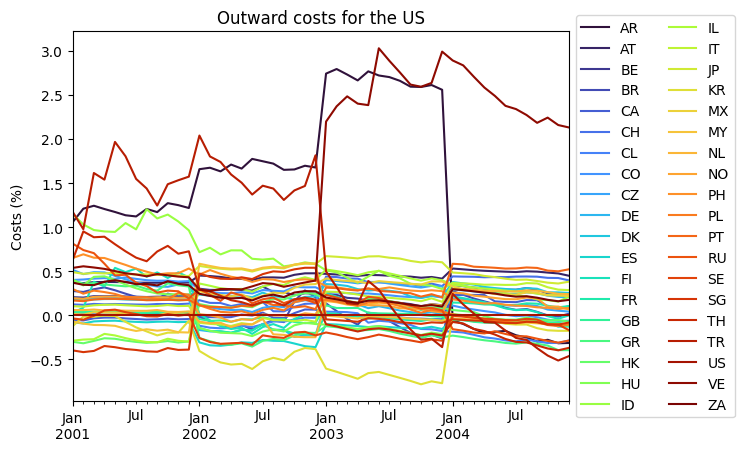

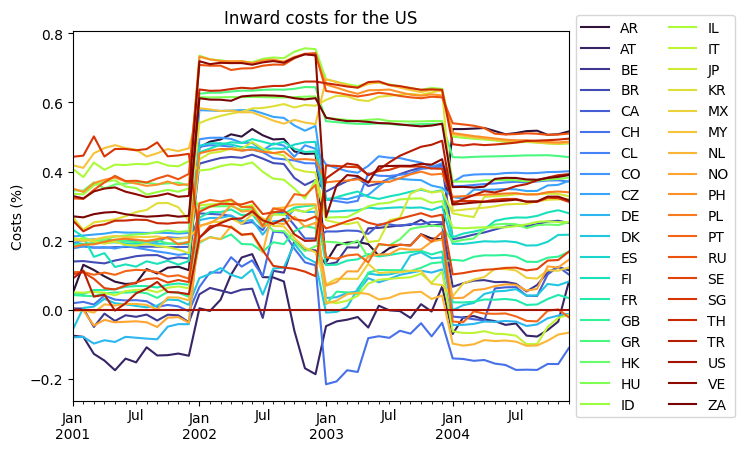

In [15]:
import matplotlib.cm as cm
data_outward = costs.loc[slice(None), (slice(None), "US")].T.droplevel(level=1)
data_inward = costs.loc["US"].unstack()
color = plt.get_cmap("turbo", 38)
ax = data_outward.plot(title="Outward costs for the US", ylabel="Costs (%)", colormap=color)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)
ax = data_inward.plot(title="Inward costs for the US", ylabel="Costs (%)", colormap=color)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2)
plt.show()

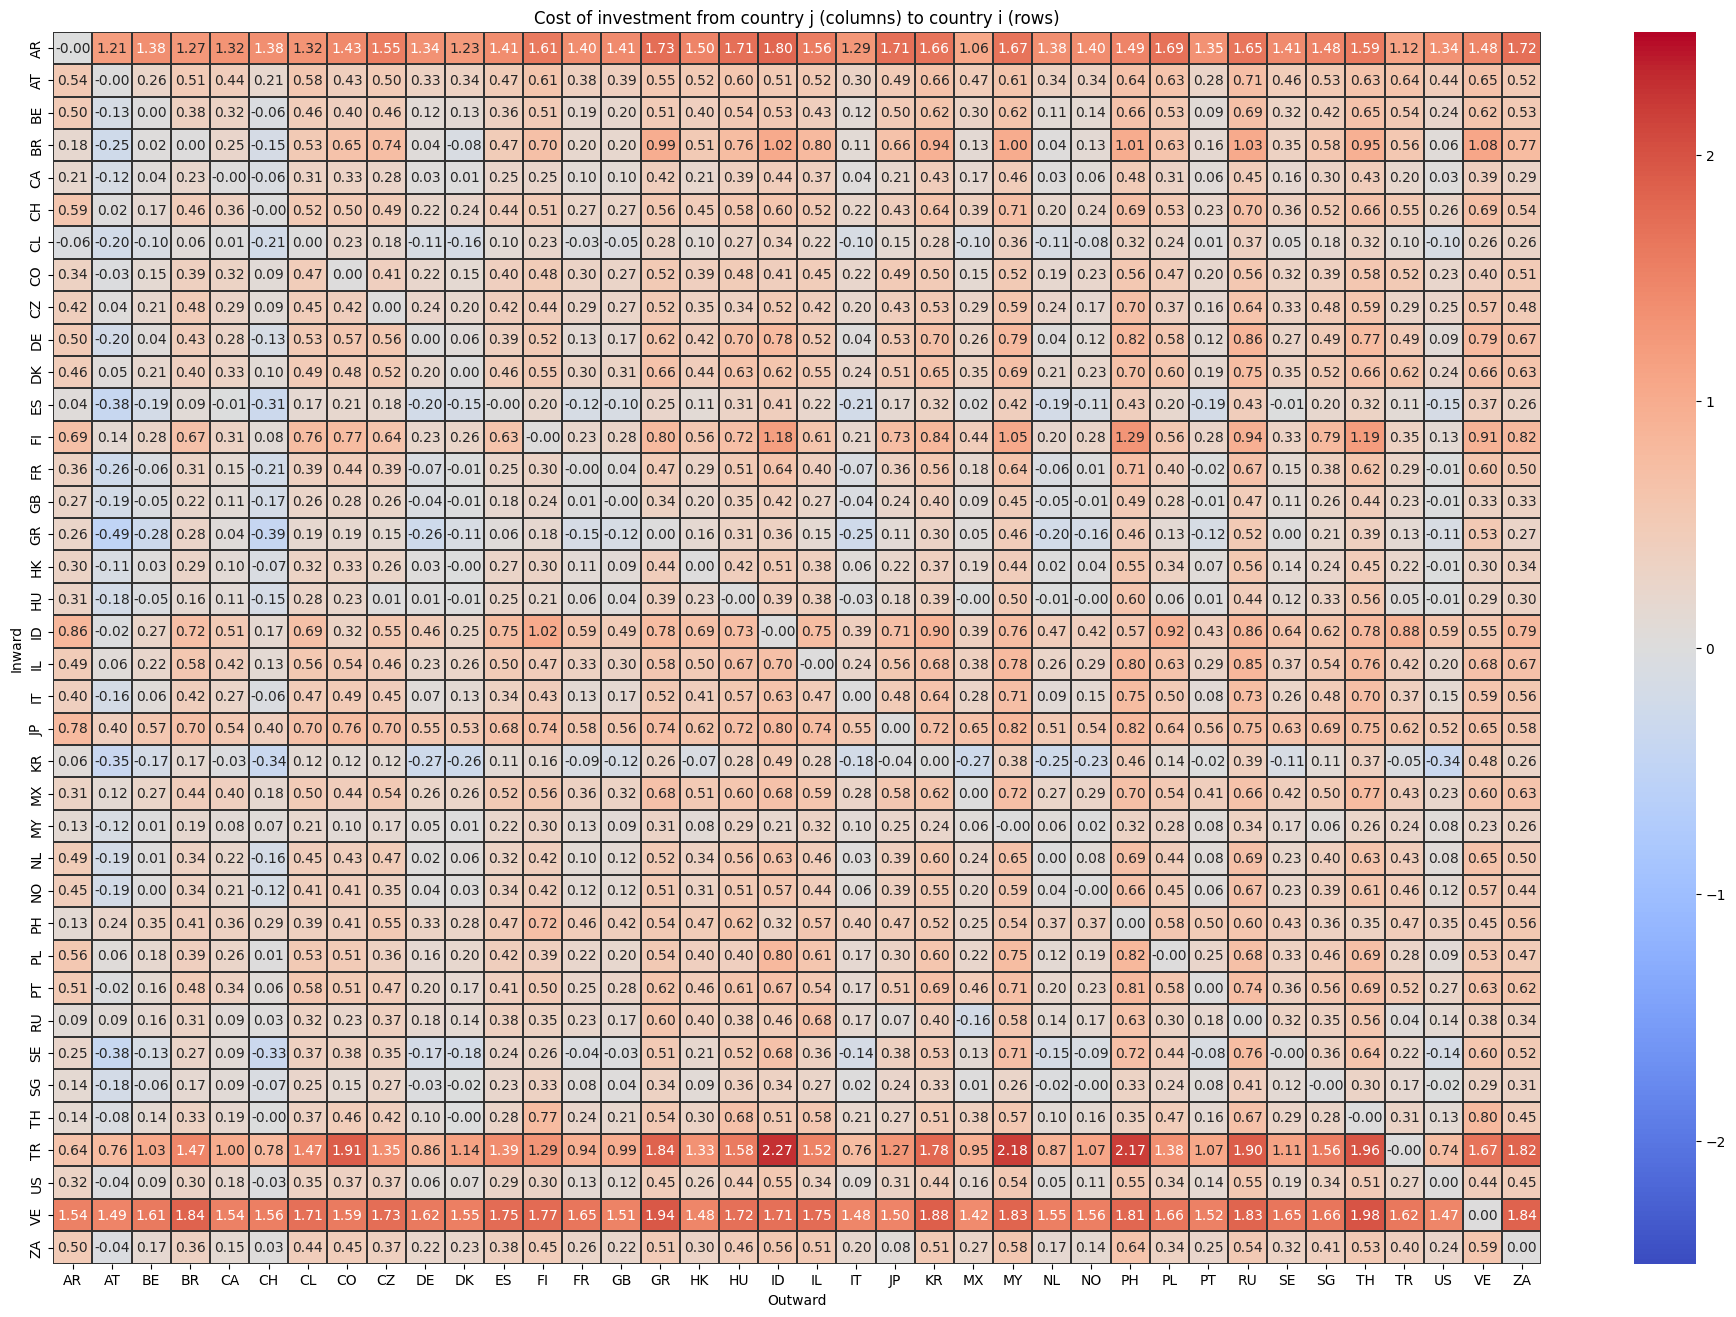

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
costs_mean = costs.T.groupby(level=1).mean().T
costs_mean = costs_mean.astype(float)
# Heatmap
plt.figure(figsize=(24, 16))
n_bins = 100  # Number of bins for the colormap
cmap = "coolwarm"
linecolor = 0.2*np.array([1, 1, 1])
sns.heatmap(costs_mean, annot=True, fmt=".2f", cmap=cmap, cbar=True, vmin=-2.5, vmax=2.5, linewidths=0.1, linecolor=linecolor)
plt.title('Cost of investment from country j (columns) to country i (rows)')
plt.xlabel("Outward")
plt.ylabel("Inward")
plt.show()

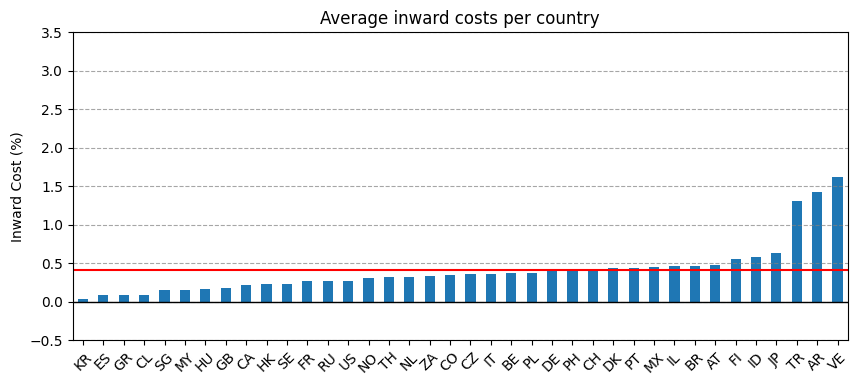

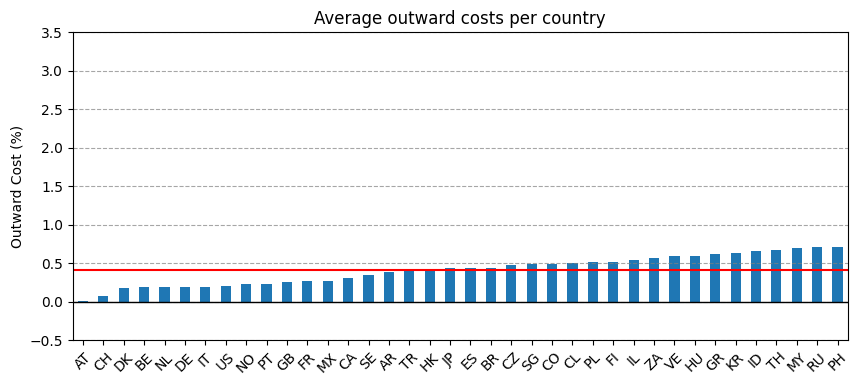

In [38]:
import matplotlib.cm as cm
import matplotlib.colors as colors
color = False
def plot_bar(series, norm, cmap, **params):
    plt.figure(figsize=(10,4))
    bar_colors = cmap(norm(series.values))
    series.plot(kind="bar", color=(bar_colors if color else None), **params)
    plt.axhline(series.mean(), color="red")
    plt.xticks(rotation=45, ha='center')
    plt.axhline(y=0, color="black", linestyle='-', linewidth=1)
    plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
    plt.ylim((-0.5,3.5))

def plot_average_costs_per_country(costs_mean, gap=False):
    mean_inward_cost = costs_mean.mean(axis=1).sort_values()
    mean_outward_cost = costs_mean.mean(axis=0).sort_values()
    norm = colors.Normalize(vmin=-4, vmax=4)
    cmap = cm.coolwarm
    if gap:
        plot_bar(mean_inward_cost, norm, cmap, edgecolor=("black" if color else None), title="Average inward cost gap per country", ylabel="Inward Cost gap (%)")
        plot_bar(mean_outward_cost, norm, cmap, edgecolor=("black" if color else None), title="Average outward cost gap per country", ylabel="Outward Cost gap (%)")
    else:
        plot_bar(mean_inward_cost, norm, cmap, edgecolor=("black" if color else None), title="Average inward costs per country", ylabel="Inward Cost (%)")
        plot_bar(mean_outward_cost, norm, cmap, edgecolor=("black" if color else None), title="Average outward costs per country", ylabel="Outward Cost (%)")
    plt.show()

plot_average_costs_per_country(costs_mean)

In [39]:
costs_mean.mean(axis=1).max()

np.float64(1.6134212286683032)

In [40]:
print("average over means: ", (costs_mean<0).sum().sum()/38**2)
print("average over all obs.: ", (costs_9<0).sum().sum()/38**2/48)

average over means:  0.10595567867036011


average over all obs.:  0.1635214681440443


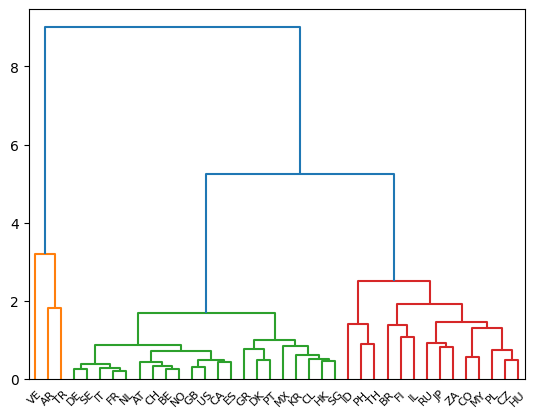

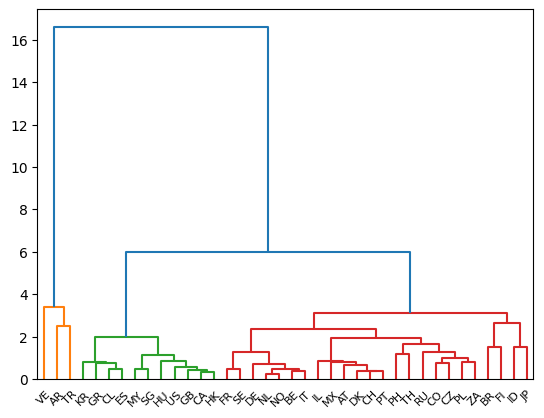

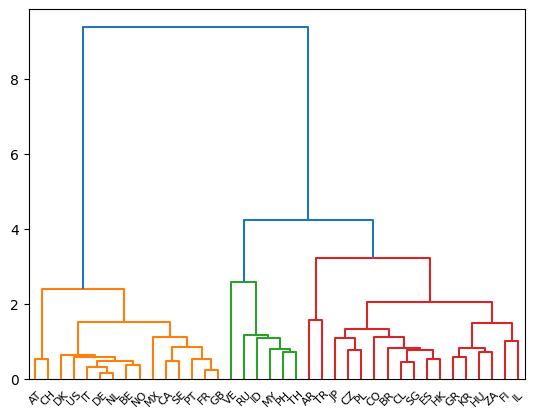

In [41]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Based on average cost between i and j
A = (costs_mean + costs_mean.T)/2 + 1
Z = linkage(A, method='ward')
dendrogram(Z, color_threshold=4, labels=major)
plt.show()

# Based on rows = inward costs
A = costs_mean
Z = linkage(A, method='ward')
dendrogram(Z, color_threshold=4, labels=major)
plt.show()

# Based on columns = outward costs
A = costs_mean.T
Z = linkage(A, method='ward')
dendrogram(Z, color_threshold=4, labels=major)
plt.show()

In [42]:
costs

2001-01-31                                                      \
              AR        AT            BE            BR            CA   
AR -2.220446e-16  0.970353  1.040276e+00  9.551381e-01  1.087165e+00   
AT  3.364801e-01  0.000000  1.966633e-01  3.722939e-01  4.062918e-01   
BE  2.224454e-01 -0.060999 -2.220446e-16  2.180930e-01  2.951152e-01   
BR -1.298550e-01 -0.026686  1.167388e-01  2.220446e-16  4.988308e-01   
CA -1.505411e-01 -0.230521 -1.069614e-01  2.265185e-02  5.551115e-17   
CH  2.131751e-01 -0.089513  3.693395e-03  1.892776e-01  2.303241e-01   
CL -1.824391e-01 -0.065064 -2.547597e-02  3.922395e-02  1.269782e-01   
CO  2.504213e-01  0.148534  2.870146e-01  4.520847e-01  5.100299e-01   
CZ  4.175368e-01  0.206489  3.962352e-01  6.770065e-01  6.361248e-01   
DE  1.999251e-01 -0.022420  8.217017e-02  2.815081e-01  3.535606e-01   
DK  1.415908e-01  0.060314  1.221826e-01  2.004985e-01  2.691611e-01   
ES -2.010170e-01 -0.294081 -1.808368e-01 -5.429763e-03  7.314694e-02   
FI  1.155039e-01 -0.017186  4.162617e-02  2.363432e-01  1.917020e-01   
FR  5.296281e-02 -0.141522 -5.532895e-02  1.346745e-01  1.819878e-01   
GB  5.788776e-02 -0.122778 -5.248060e-02  1.147746e-01  1.603064e-01   
GR  4.793079e-01 -0.058095  1.294993e-01  6.730777e-01  6.191426e-01   
HK -2.878494e-01 -0.462452 -3.439934e-01 -1.380509e-01 -1.334750e-01   
HU  4.753413e-01  0.145270  2.706860e-01  4.480720e-01  6.074934e-01   
ID  1.216547e+00  0.501698  7.843351e-01  1.174975e+00  1.152766e+00   
IL -2.863933e-01 -0.452470 -3.478109e-01 -7.780614e-02 -7.659918e-02   
IT  5.422022e-02 -0.158693 -2.572381e-02  2.010028e-01  2.391141e-01   
JP  6.102865e-01  0.349124  4.847508e-01  5.960850e-01  5.512867e-01   
KR -1.536256e-01 -0.218017 -8.057905e-02  1.936661e-01  2.433120e-01   
MX -2.457052e-01 -0.142396 -2.829202e-02  8.861122e-02  2.263271e-01   
MY -2.365134e-01 -0.335857 -1.942341e-01 -2.393045e-02 -9.704220e-03   
NL  1.235832e-01 -0.124337 -4.351337e-02  1.228289e-01  1.781949e-01   
NO  2.122057e-01 -0.080690  3.172907e-02  2.544602e-01  3.215454e-01   
PH  1.355019e-01  0.502305  6.084523e-01  6.458462e-01  6.988300e-01   
PL  4.674022e-01  0.189229  2.780892e-01  4.410507e-01  5.341666e-01   
PT  1.498952e-01 -0.094717  1.408152e-02  2.360997e-01  2.754997e-01   
RU  3.125010e-01  0.682013  7.469232e-01  8.677593e-01  8.587470e-01   
SE -8.296319e-02 -0.258579 -1.271161e-01  1.108753e-01  1.859848e-01   
SG -5.014534e-01 -0.601719 -5.104551e-01 -3.291903e-01 -2.581106e-01   
TH  2.437333e-01  0.397757  5.703067e-01  6.921294e-01  7.577214e-01   
TR  2.545601e-01  1.073956  1.222686e+00  1.502569e+00  1.521174e+00   
US  4.747241e-02 -0.075365  3.473974e-03  1.394423e-01  1.830583e-01   
VE  3.914134e-01  0.515696  5.664081e-01  6.926896e-01  6.134517e-01   
ZA  4.209308e-01  0.089782  2.585152e-01  3.887959e-01  3.697021e-01   

                                                                  ...  \
              CH        CL            CO            CZ        DE  ...   
AR  1.094335e+00  0.991966  1.013447e+00  1.102091e+00  0.991205  ...   
AT  2.461510e-01  0.436992  2.677031e-01  3.713983e-01  0.226879  ...   
BE  9.155632e-02  0.282692  1.937394e-01  2.827995e-01  0.041108  ...   
BR  2.155680e-01  0.444214  4.697596e-01  6.151915e-01  0.032603  ...   
CA -8.243584e-02  0.113007  9.176404e-02  7.835540e-02 -0.173903  ...   
CH  5.551115e-17  0.239494  1.873263e-01  2.118807e-01 -0.007913  ...   
CL  7.424195e-03  0.000000  1.197950e-01  1.135525e-01 -0.066679  ...   
CO  3.438712e-01  0.516332  1.110223e-16  4.607845e-01  0.304421  ...   
CZ  4.076168e-01  0.646318  5.525390e-01 -4.440892e-16  0.364113  ...   
DE  1.357363e-01  0.349812  3.378239e-01  3.807927e-01  0.000000  ...   
DK  1.586871e-01  0.255252  2.176488e-01  2.758426e-01  0.092196  ...   
ES -1.302758e-01  0.062218  5.840412e-02  7.721732e-02 -0.246535  ...   
FI  4.316456e-02  0.301180  2.808213e-01  2.165515e-01 -0.059568  ...   
FR -1.385303e-02  0.190863  1.

In [43]:
cost_gap = pd.DataFrame(0.0, index=costs.index, columns=costs.columns)
for month in stds.columns:
    cost_gap[month] = 300 * covs[month] @ weights - costs[month]

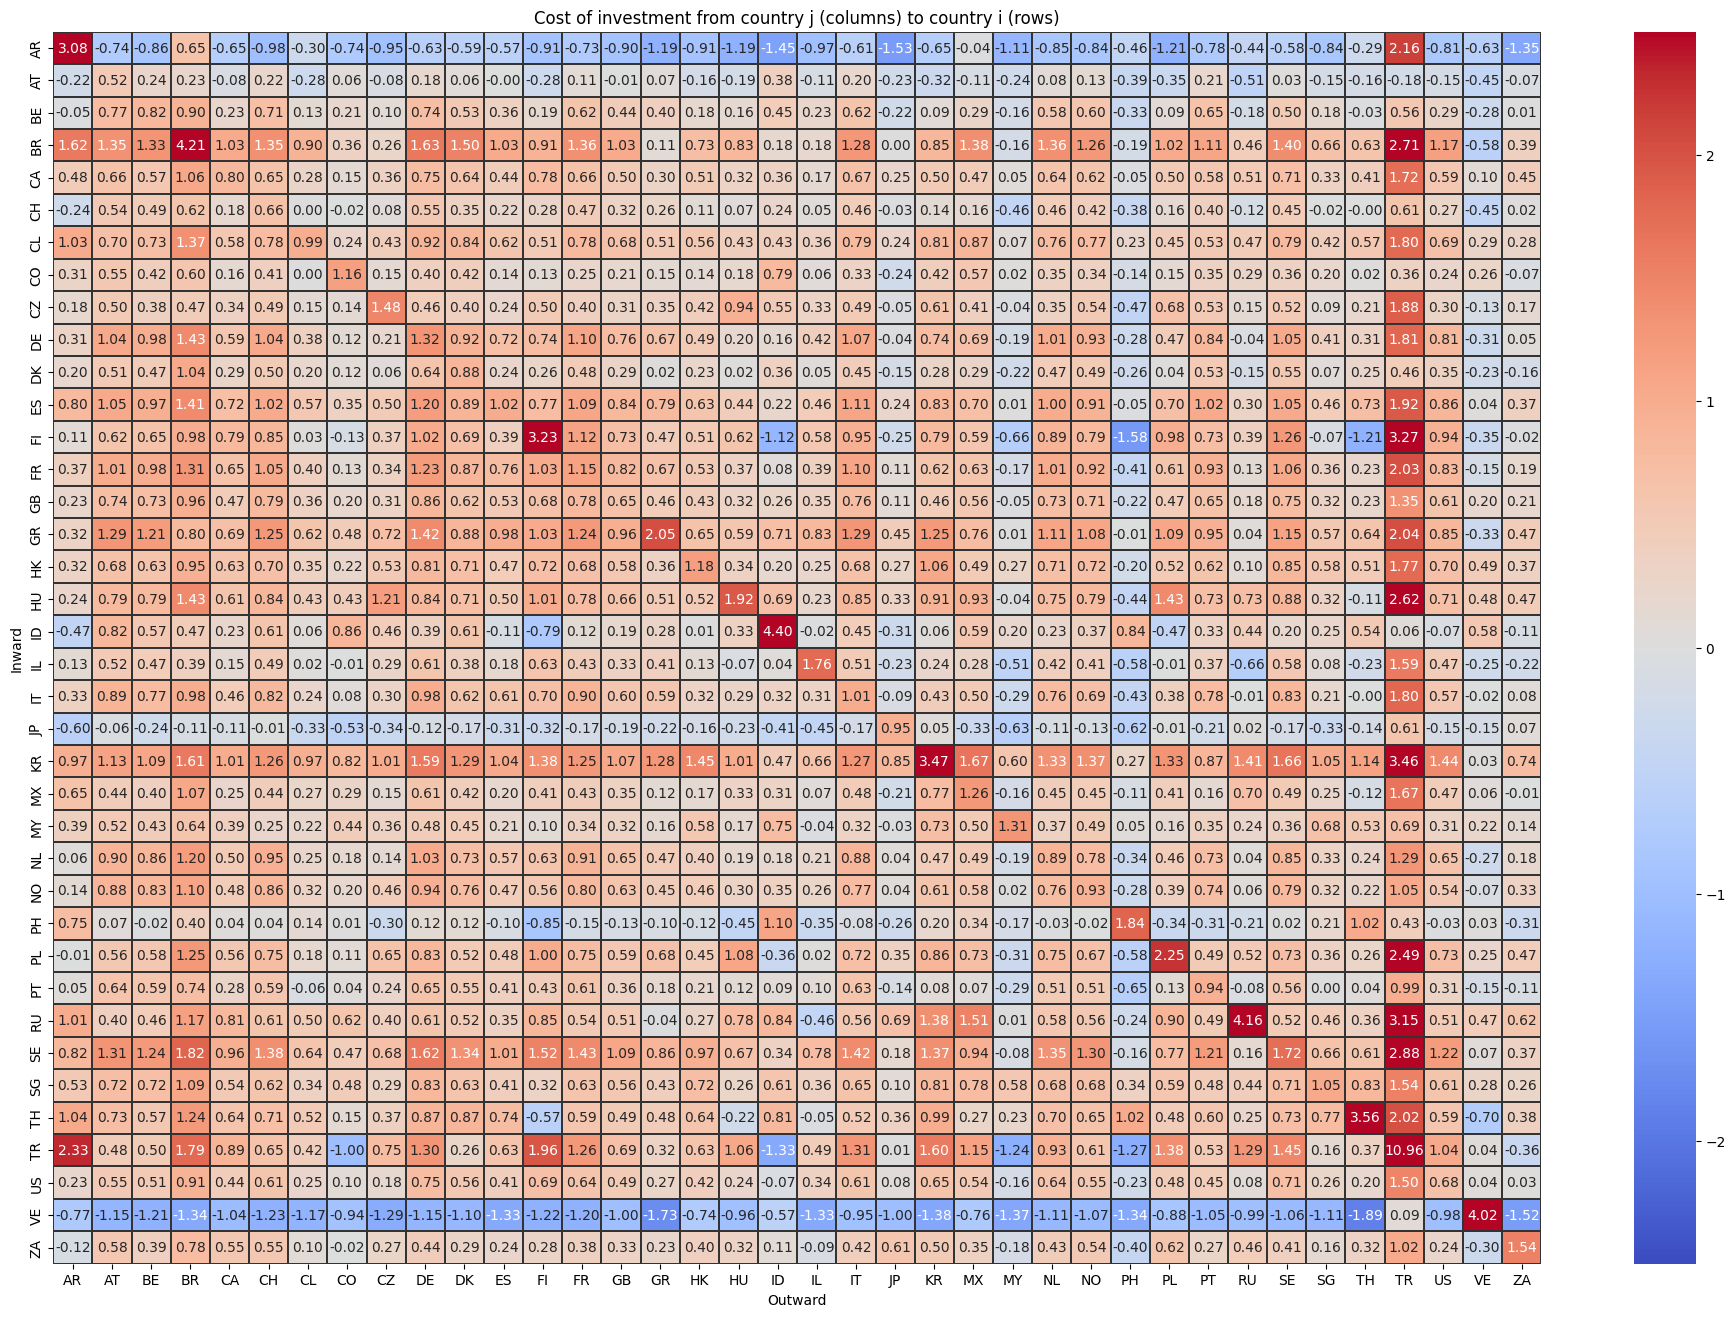

In [44]:
cost_gap
cost_gap_mean = cost_gap.T.groupby(level=1).mean().T
cost_gap_mean = cost_gap_mean.astype(float)
# Heatmap
plt.figure(figsize=(24, 16))
n_bins = 100  # Number of bins for the colormap
cmap = "coolwarm"
linecolor = 0.2*np.array([1, 1, 1])
sns.heatmap(cost_gap_mean, annot=True, fmt=".2f", cmap=cmap, cbar=True, vmin=-2.5, vmax=2.5, linewidths=0.1, linecolor=linecolor)
plt.title('Cost of investment from country j (columns) to country i (rows)')
plt.xlabel("Outward")
plt.ylabel("Inward")
plt.show()

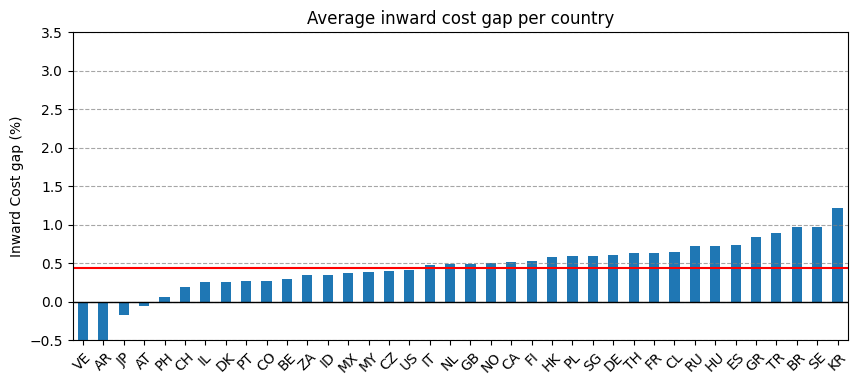

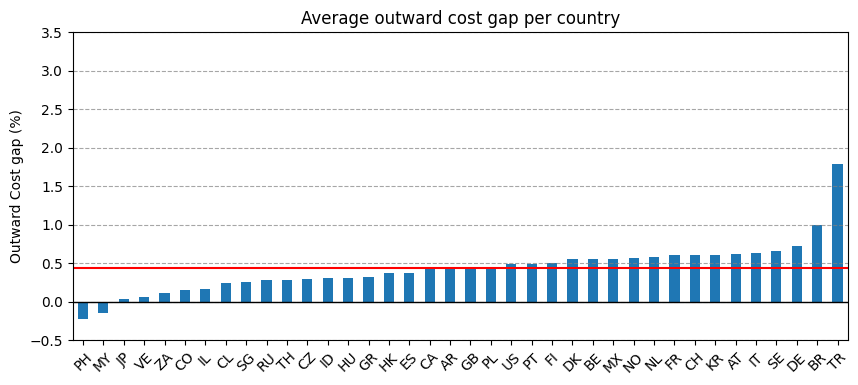

In [45]:
plot_average_costs_per_country(cost_gap_mean, gap=True)